In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 

from traffic.core import Traffic

/tmp/ipykernel_3929339/251887701.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from traffic.data import opensky
from traffic.data import eurofirs
from traffic.core.structure import Airport




In [3]:
from traffic.data import airports

In [28]:
airports["LFPO"].bounds

(2.3102788, 48.7138931, 2.4073124, 48.7462217)

In [15]:

# from traffic.data import airports, nm_airspaces

In [4]:
def add_NM_to_lat_long(nm: float, lon: float, lat: float, sub: bool = False):
    """
    Add nm nautical miles to the  latitude and longitude
    """

    new_lat = lat + nm / 60 if not sub else lat - nm / 60
    new_lon = (
        lon + nm / (60 * np.cos(np.deg2rad(lat)))
        if not sub
        else lon - nm / (60 * np.cos(np.deg2rad(lat)))
    )
    return float(new_lon), new_lat

In [5]:
def add_to_bounds(bounds, nm: float):
    return tuple(list(add_NM_to_lat_long(nm, bounds[0], bounds[1],sub =True)) + list(
        add_NM_to_lat_long(nm, bounds[2], bounds[3]))
    )

In [6]:
add_to_bounds(airports["LFPO"].bounds, 10)

(2.0576844597761768,
 48.547226433333336,
 2.6600691958178824,
 48.912888366666664)

In [7]:
def months_between(d1, d2):
    # Ensure d1 <= d2
    if d1 > d2:
        d1, d2 = d2, d1
    return (d2.year - d1.year) * 12 + (d2.month - d1.month)

In [8]:
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def filter_flight(flight):
    """
    Function to filter flights based on the condition.
    """
    try:
        return flight.takeoff_from_runway("LFPO").next().runway_max[-1] == "7"
    except Exception:
        return False

# Multiprocessing function
def filter_flights_multiprocess(landings_orly,max_workers = 1):
    if max_workers > cpu_count():
        max_workers = cpu_count()
    with Pool(max_workers) as pool:
        # Use Pool to parallelize the filtering
        results = list(
            tqdm(
                pool.imap(filter_flight, landings_orly),
                total=len(landings_orly),
                desc="Filtering flights",
            )
        )
    # Select flights that meet the condition
    selected = [f for f, keep in zip(landings_orly, results) if keep]
    return selected

In [ ]:
import datetime
from dateutil.relativedelta import relativedelta

airport_name = "LFPO"
start = datetime.datetime(2024, 12, 1)
end = datetime.datetime(2024, 12, 31)

airport = airports[airport_name]
bounds = airport.bounds
bounds = add_to_bounds(bounds, 50)
print(bounds)
months = months_between(start, end)
print(months)
total_traffs = None
for i in range(months+1):
    new_start = start + relativedelta(months=i)
    new_end = start + relativedelta(months=i + 1)
    print(f"|-- Start = {new_start}, End = {new_end} --|")

    try:
        landings_orly = opensky.history(
            start=new_start,
            stop=new_end,
            departure_airport="LFPO",
            bounds=bounds,
        )
        landings_orly = landings_orly.resample(250).eval(desc="Resampling flights",max_workers=8)
        # data = landings_orly
        # data = 
        print("Data loaded successfully")
        selected = filter_flights_multiprocess(landings_orly,max_workers = 8)
        # print(f"Selected {len(selected)} flights")
        # landings_orly = sum(selected)
        if i == 0:
            total_traffs = landings_orly
        else:
            total_traffs += landings_orly
    except Exception as e:
        print(f"Error: {e}")

(1.0473070988808837, 47.880559766666664, 3.6710963790894127, 49.579555033333335)
0
|-- Start = 2024-12-01 00:00:00, End = 2025-01-01 00:00:00 --|


Resampling flights:   0%|          | 0/6773 [00:00<?, ?it/s]

Data loaded successfully


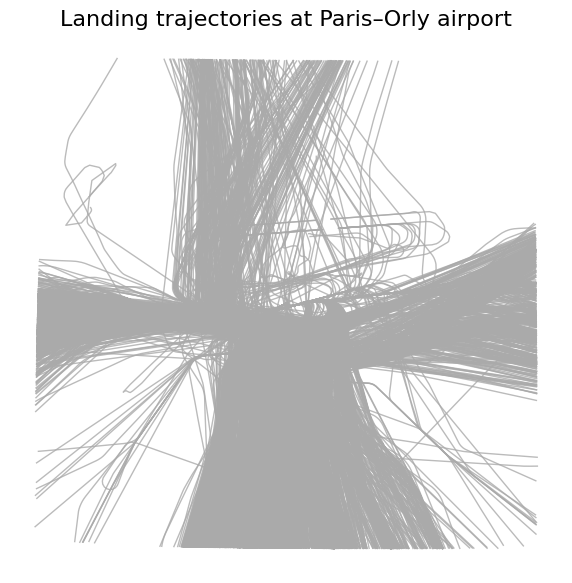

In [12]:
from cartes.crs import Lambert93
from traffic.data import airports

with plt.style.context("traffic"):

    fig, ax = plt.subplots(subplot_kw=dict(projection=Lambert93()))

    #airports["LFPO"].plot(ax, footprint=False, runways=dict(linewidth=1))
    total_traffs.plot(ax)

    ax.set_title("Landing trajectories at Paris–Orly airport")

In [62]:
landings_orly.data.dtypes

timestamp                     datetime64[ns, UTC]
icao24                            string[pyarrow]
latitude                          double[pyarrow]
longitude                         double[pyarrow]
groundspeed                       double[pyarrow]
track                                     float64
vertical_rate                     double[pyarrow]
callsign                          string[pyarrow]
onground                            bool[pyarrow]
alert                               bool[pyarrow]
spi                                 bool[pyarrow]
squawk                            string[pyarrow]
altitude                          double[pyarrow]
geoaltitude                       double[pyarrow]
lastcontact                       double[pyarrow]
serials                                    object
hour               timestamp[ns, tz=UTC][pyarrow]
track_unwrapped                           float64
dtype: object

In [68]:
landings_orly[0].data

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,onground,alert,spi,squawk,altitude,geoaltitude,lastcontact,serials,hour,track_unwrapped
0,2024-12-31 06:57:38+00:00,020044,<NA>,<NA>,126.0,242.007947,0.0,RAM623,False,False,False,7622,<NA>,425.0,1735628257.951,[1549047001],2024-12-31 06:00:00+00:00,242.007947
1,2024-12-31 06:57:40.730923694+00:00,020044,<NA>,<NA>,145.0,241.672558,0.0,RAM623,False,False,False,7622,<NA>,425.0,1735628260.826,[1549047001],2024-12-31 06:00:00+00:00,241.672558
2,2024-12-31 06:57:43.461847389+00:00,020044,<NA>,<NA>,149.0,241.882130,64.0,RAM623,False,False,False,7622,<NA>,425.0,1735628262.743,[1549047001],2024-12-31 06:00:00+00:00,241.882130
3,2024-12-31 06:57:46.192771084+00:00,020044,<NA>,<NA>,149.0,241.882130,64.0,RAM623,False,False,False,7622,<NA>,425.0,1735628262.743,[1549047001],2024-12-31 06:00:00+00:00,241.882130
4,2024-12-31 06:57:48.923694779+00:00,020044,48.72551,2.332482,165.0,242.192958,1152.0,RAM623,False,False,False,7622,-125.0,450.0,1735628268.969,[1549047001],2024-12-31 06:00:00+00:00,242.192958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2024-12-31 07:08:47.076305220+00:00,020044,47.902439,2.01578,410.0,188.703634,2176.0,RAM623,False,False,False,7622,22200.0,22825.0,1735628926.947,"[1549047001, -1408230116, -1408215291, 5964022...",2024-12-31 07:00:00+00:00,188.703634
246,2024-12-31 07:08:49.807228915+00:00,020044,47.897003,2.014343,410.0,190.404904,2176.0,RAM623,False,False,False,7622,22300.0,22950.0,1735628929.98,"[1549047001, -1408230116, -1408215291, 5964022...",2024-12-31 07:00:00+00:00,190.404904
247,2024-12-31 07:08:52.538152610+00:00,020044,47.891235,2.012627,410.0,191.529036,2176.0,RAM623,False,False,False,7622,22400.0,23000.0,1735628932.985,"[1549047001, -1408230116, -1408215291, 5964022...",2024-12-31 07:00:00+00:00,191.529036
248,2024-12-31 07:08:55.269076305+00:00,020044,47.887542,2.011343,411.0,193.224551,2048.0,RAM623,False,False,False,7622,22475.0,23125.0,1735628934.966,"[1549047001, -1408230116, -1408215291, 5964022...",2024-12-31 07:00:00+00:00,193.224551


In [58]:
filter_flights_multiprocess(landings_orly,max_workers = 8)

Filtering flights:  11%|█▏        | 775/6773 [01:37<12:33,  7.97it/s] Process ForkPoolWorker-8:

Process ForkPoolWorker-6:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/arnault/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/arnault/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/arnault/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/arnault/.local/share/uv/python/cpython-3.12.9-linux-

KeyboardInterrupt: 

In [52]:
landings_orly[10].takeoff_from_runway("LFPO").next().runway_max

'07'

In [10]:
from traffic.core import Traffic
test = Traffic.from_file('/home/arnault/traffic/data/takeoffs_LFPO_07.pkl')
print(test[0].data)

                     timestamp  altitude callsign  groundspeed  icao24  \
0    2022-07-12 12:46:36+00:00    3175.0   AEA009        162.0  3451cf   
1    2022-07-12 12:46:38+00:00    3250.0   AEA009        163.0  3451cf   
2    2022-07-12 12:46:42+00:00    3500.0   AEA009        166.0  3451cf   
3    2022-07-12 12:46:44+00:00    3575.0   AEA009        169.0  3451cf   
4    2022-07-12 12:46:48+00:00    3750.0   AEA009        176.0  3451cf   
..                         ...       ...      ...          ...     ...   
195  2022-07-12 12:55:56+00:00   29375.0   AEA009        493.0  3451cf   
196  2022-07-12 12:56:00+00:00   29525.0   AEA009        495.0  3451cf   
197  2022-07-12 12:56:02+00:00   29600.0   AEA009        495.0  3451cf   
198  2022-07-12 12:56:06+00:00   29725.0   AEA009        496.0  3451cf   
199  2022-07-12 12:56:08+00:00   29750.0   AEA009        496.0  3451cf   

      latitude  longitude origin squawk       track  vertical_rate  \
0    48.735957   2.449445   LFPO   7671  

In [47]:
landings_orly.to_pickle(filename="/home/arnault/traffic/data/unprocessed/TO_orly_2024.pkl")